In [1]:
%matplotlib inline

In [2]:
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import scipy.stats
import skimage.exposure
import skimage.feature
import skimage.filters
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.restoration
import skimage.segmentation

# Introduction to three-dimensional image processing

The `skimage` library represents images as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Some 3D images are constructed with equal resolution in each dimension; e.g., a computer generated rendering of a sphere. Most experimental data captures one dimension at a lower resolution than the other two; e.g., photographing thin slices to approximate a 3D structure as a stack of 2D images. The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.

## Input/Output and display

Three dimensional data can be loaded with `skimage.io.imread`. The data for this tutorial was provided by the Allen Institute for Cell Science. It has been downsampled by a factor of 4 in the `row` and `column` dimensions to reduce computational time.

In [3]:
data = skimage.io.imread("../images/cells.tif")

print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))

shape: (60, 256, 256)
dtype: float64


The distance between pixels is defined in the image metadata when the image was captured. It is reported by the microscope used the image the cells. The `spacing` will be used to adjust contributions to filters and helps decide when to apply operations planewise. We've chosen to normalize it `1.0` in the `row` and `column` dimensions.

In [4]:
original_spacing = (0.2900000, 0.0650000, 0.0650000)

spacing = tuple(np.divide(original_spacing, original_spacing[1]))

print("spacing: {}".format(spacing))

spacing: (4.4615384615384608, 1.0, 1.0)


Try visualizing the image with `skimage.io.imshow`...

Invalid dimensions for image data


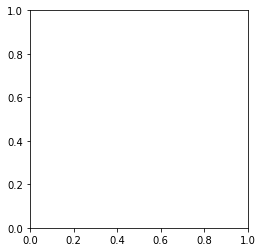

In [5]:
try:
    skimage.io.imshow(data, cmap="gray")
except TypeError as e:
    print(str(e))

Too bad! `skimage.io.imshow` can only display grayscale and RGB(A) 2D images. We can use `skimage.io.imshow` to visualize 2D planes. By fixing one axis, we can observe three different views of the 3D image.

In [6]:
def show_plane(ax, plane, cmap="gray", title=None):
    ax.imshow(plane, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if title:
        ax.set_title(title)

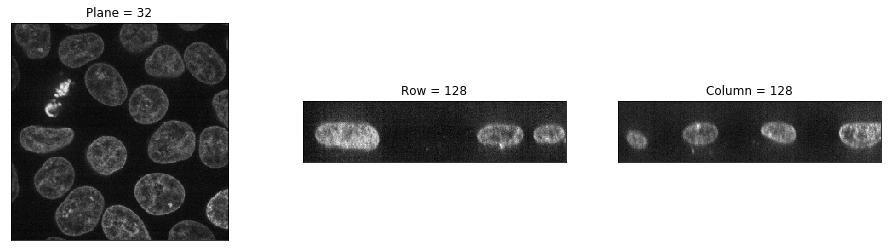

In [7]:
_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

show_plane(a, data[32], title="Plane = 32")
show_plane(b, data[:, 128, :], title="Row = 128")
show_plane(c, data[:, :, 128], title="Column = 128")

Three-dimensional images can be viewed as a series of two-dimensional functions. The `display` helper function displays 30 planes of the provided image. By default, every other plane is displayed.

In [8]:
def display(im3d, cmap="gray", step=2):
    _, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 14))
    
    vmin = im3d.min()
    vmax = im3d.max()
    
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])

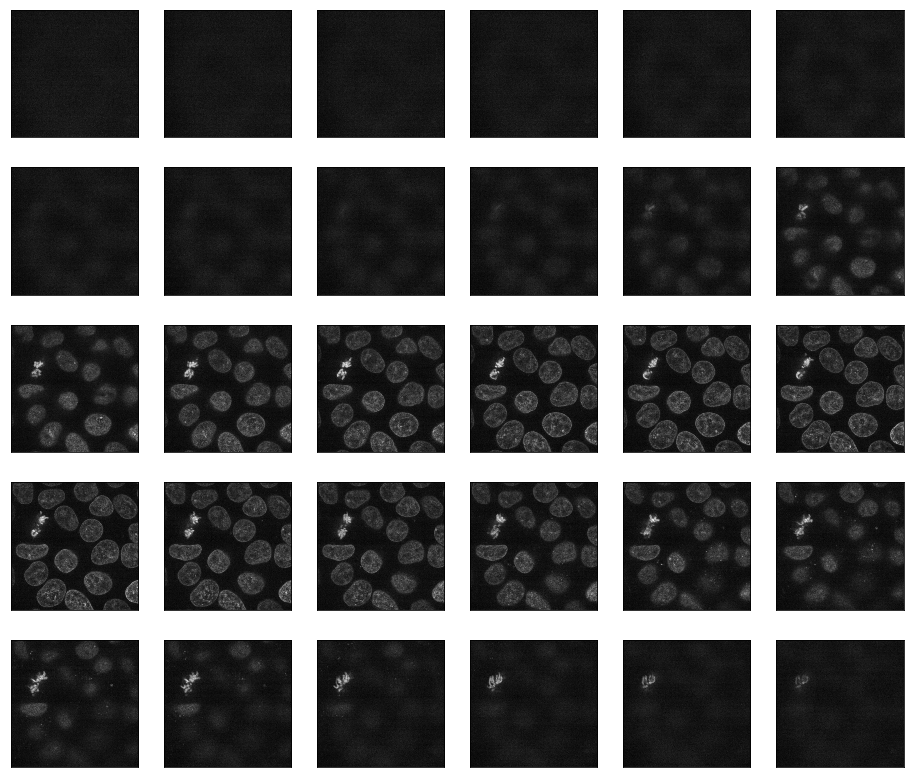

In [9]:
display(data)

## Exposure

In [10]:
# Helper function for plotting histograms.
def plot_hist(ax, data, title=None):
    ax.hist(data.ravel(), bins=256)
    ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
    
    if title:
        ax.set_title(title)

`skimage.expsoure` contains a number of functions for adjusting image contrast. These functions operate on pixel values. Generally, image dimensionality or pixel spacing does not need to be considered.

[Gamma correction](https://en.wikipedia.org/wiki/Gamma_correction), also known as Power Law Transform, brightens or darkens an image. The function `O = I**gamma` is applied to each pixel in the image. A `gamma < 1` will brighten an image, while a `gamma > 1` will darken an image.

Logarithmic correction adjusts contrast with a logarithmic function by applying the function `O = gain*log(1 + I)` pixelwise.

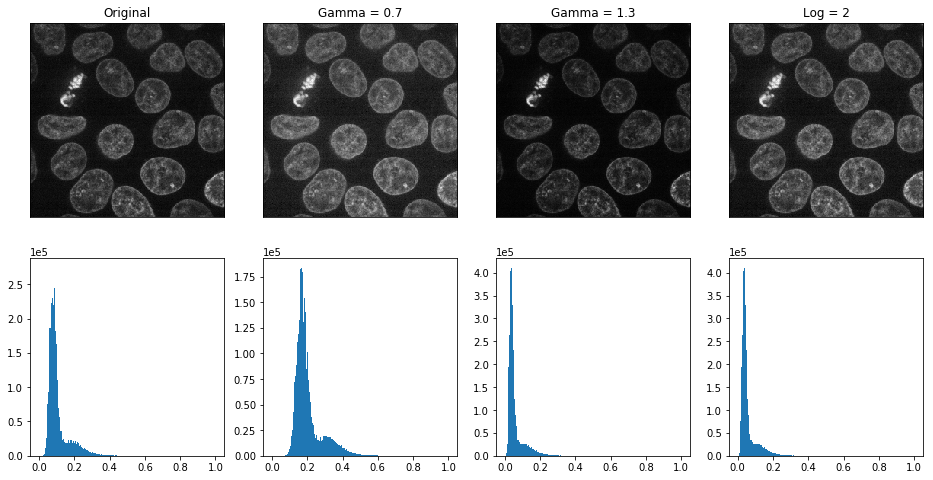

In [14]:
gamma_low_val = 0.7
gamma_low = skimage.exposure.adjust_gamma(data, gamma=gamma_low_val)

gamma_high_val = 1.3
gamma_high = skimage.exposure.adjust_gamma(data, gamma=gamma_high_val)

log_val = 2
log = skimage.exposure.adjust_log(data, gain=log_val)

_, ((a, b, c, d), (f, g, h, i)) = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

show_plane(a, data[32], title="Original")
show_plane(b, gamma_low[32], title="Gamma = {}".format(gamma_low_val))
show_plane(c, gamma_high[32], title="Gamma = {}".format(gamma_high_val))
show_plane(d, log[32], title="Log = {}".format(log_val))

plot_hist(f, data)
plot_hist(g, gamma_low)
plot_hist(h, gamma_high)
plot_hist(i, gamma_high)

[Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) improves contrast in an image by adjusting the pixel intensity histogram. The most common pixel intensities are redistributed such that the equalized image has a linear cumulative distribution function. After histogram equalization, areas of lower local contrast gain a higher contrast. Histogram equalization often has an undesirable side-effect; it can enhance noise.

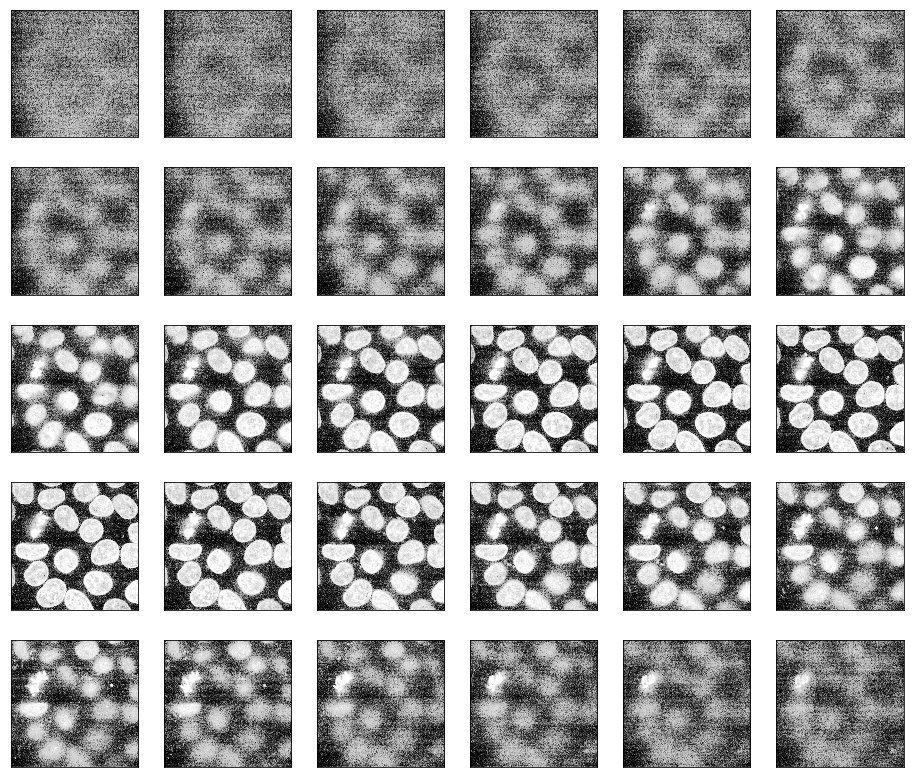

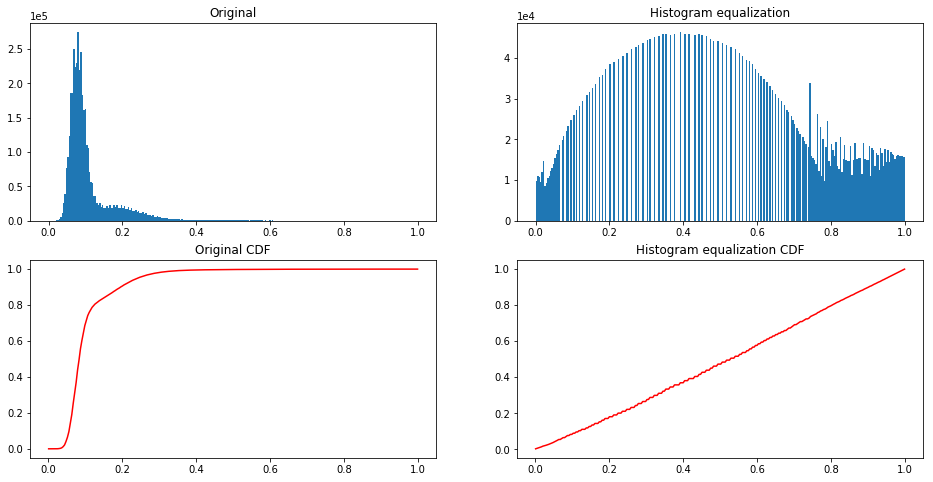

In [15]:
equalized = skimage.exposure.equalize_hist(data)

display(equalized)

_, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

plot_hist(a, data, title="Original")
plot_hist(b, equalized, title="Histogram equalization")

cdf, bins = skimage.exposure.cumulative_distribution(data.ravel())
c.plot(bins, cdf, "r")
c.set_title("Original CDF")

cdf, bins = skimage.exposure.cumulative_distribution(equalized.ravel())
d.plot(bins, cdf, "r")
d.set_title("Histogram equalization CDF");

Most experimental images are affected by salt and pepper noise. A few bright artifacts can decrease the relative intensity of the pixels of interest. A simple way to improve contrast is to clip the pixel values on the lowest and highest extremes. Clipping the darkest and brightest 0.5% of pixels will increase the overall contrast of the image.

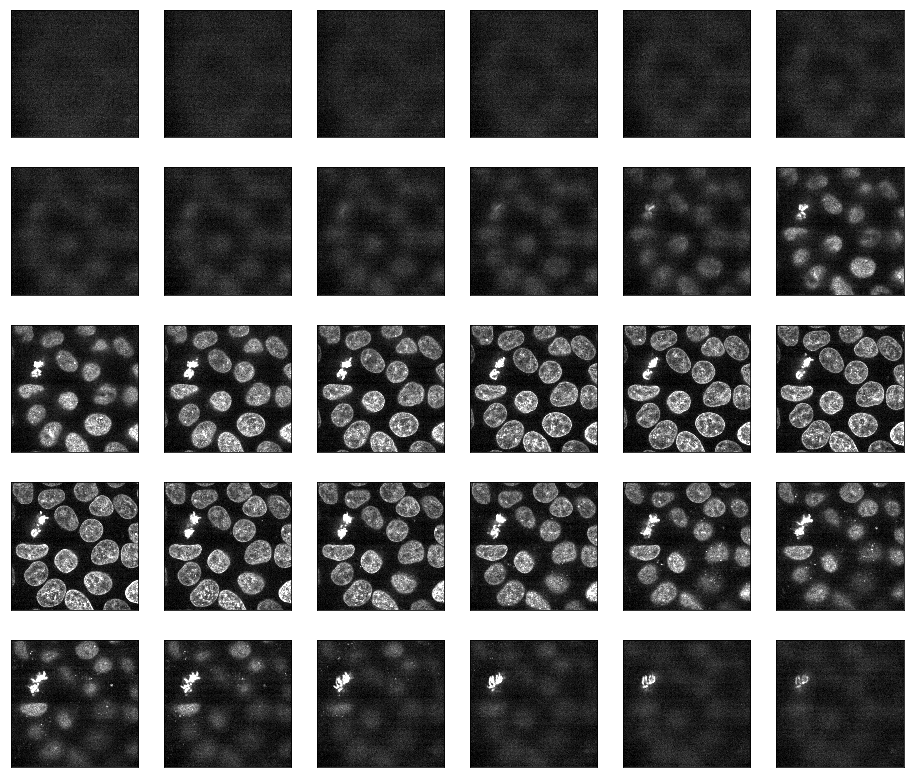

In [16]:
vmin, vmax = scipy.stats.scoreatpercentile(data, (0.5, 99.5))

clipped = skimage.exposure.rescale_intensity(
    data, 
    in_range=(vmin, vmax), 
    out_range=np.float32
).astype(np.float32)

display(clipped)

In [18]:
rescaled = clipped

## Edge detection

[Edge detection](https://en.wikipedia.org/wiki/Edge_detection) highlights regions in the image where a sharp change in contrast occurs. The intensity of an edge corresponds to the steepness of the transition from one intensity to another. A gradual shift from bright to dark intensity results in a dim edge. An abrupt shift results in a bright edge.

The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is an edge detection algorithm which approximates the gradient of the image intensity, and is fast to compute. `skimage.filters.sobel` has not been adapted for 3D images. It can be applied planewise to approximate a 3D result.

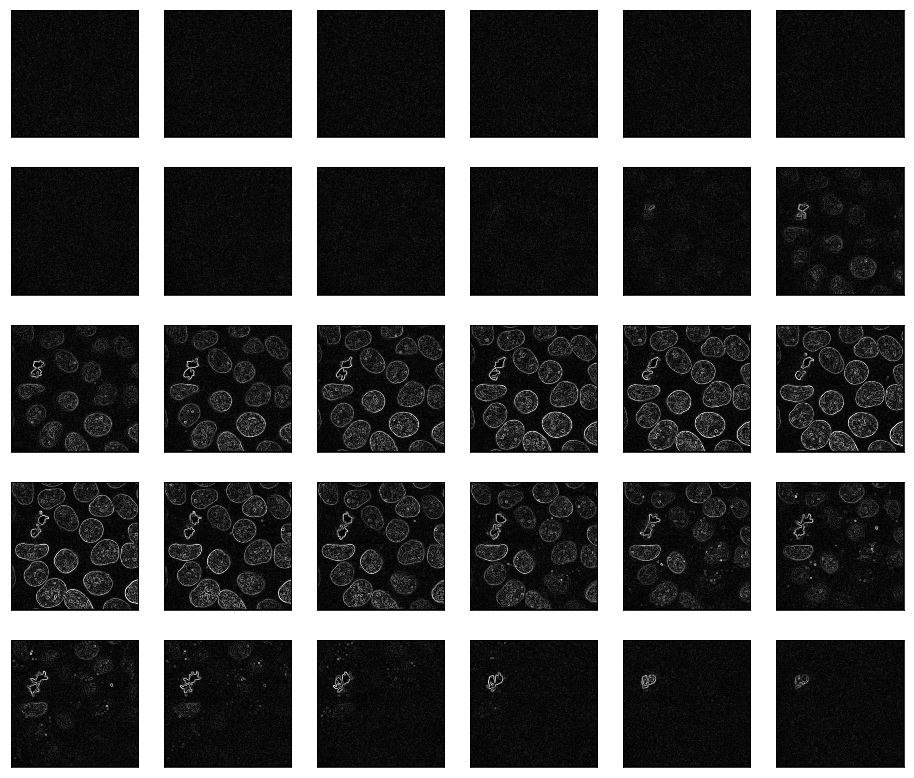

In [19]:
sobel = np.empty_like(rescaled)

for plane, image in enumerate(rescaled):
    sobel[plane] = skimage.filters.sobel(image)
    
display(sobel)

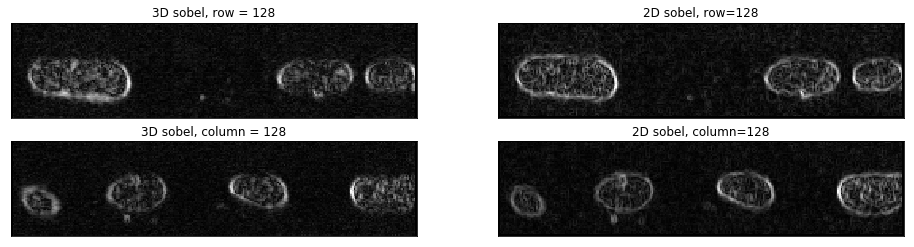

In [24]:
_, ((a, b), (c, d)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 4))

show_plane(a, sobel[:, 128, :], title="3D sobel, row = 128")

row_sobel = skimage.filters.sobel(rescaled[:, 128, :])
show_plane(b, row_sobel, title="2D sobel, row=128")

show_plane(c, sobel[:, :, 128], title="3D sobel, column = 128")

column_sobel = skimage.filters.sobel(rescaled[:, :, 128])
show_plane(d, column_sobel, title="2D sobel, column=128")

## Filters

In addition to edge detection, `skimage.filters` provides functions for filtering and thresholding images.

[Gaussian filter](https://en.wikipedia.org/wiki/Gaussian_filter) applies a Gaussian function to an image, creating a smoothing effect. `skimage.filters.gaussian` takes as input `sigma` which can be a scalar or a sequence of scalar. This `sigma` determines the standard deviation of the Gaussian along each axis. The spacing in the `plane` dimension is much greater than the `row` and `column` dimensions. Dividing `base_sigma` by the image `spacing` will reduce the contribution of pixels in the `plane` dimension.

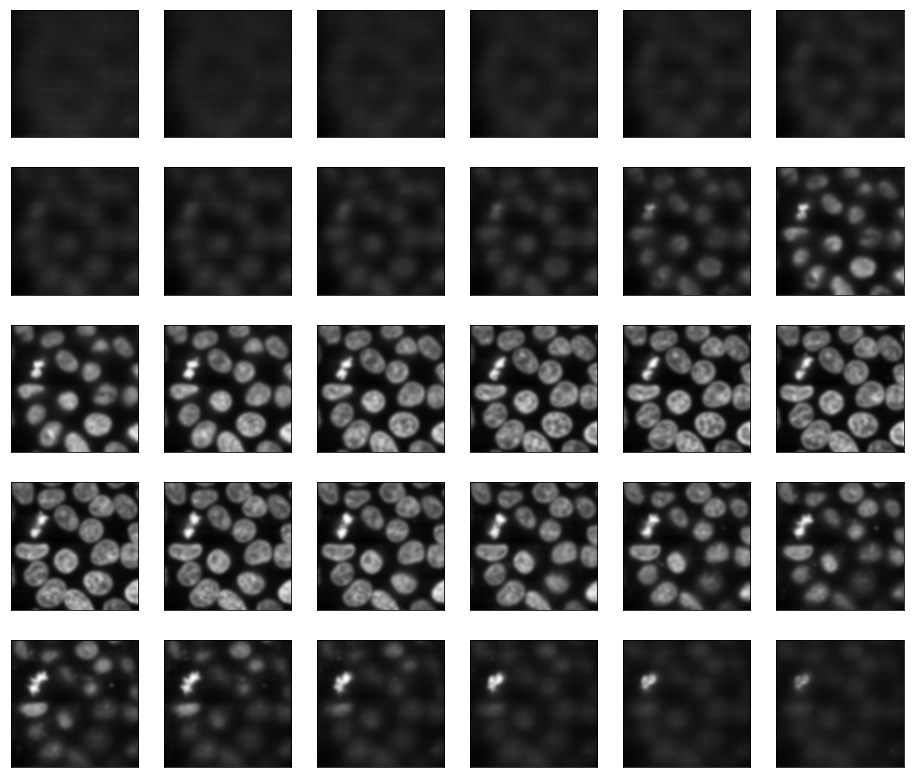

In [26]:
base_sigma = 3.0

sigma = np.divide(base_sigma, spacing)

gaussian = skimage.filters.gaussian(rescaled, multichannel=False, sigma=sigma)

display(gaussian)

[Median filter](https://en.wikipedia.org/wiki/Median_filter) is a noise removal filter. It is particularly effective against salt and pepper noise. An additional feature of the median filter is its ability to preserve edges. This is helpful in segmentation because the original shape of regions of interest will be preserved.

`skimage.filters.median` does not support three-dimensional images and needs to be applied planewise. The chosen structuring element, which defines the neighborhoods the filter is applied to, is smaller than the spacing in the `plane` dimension. No contribution from planes above and below each neighborhood is expected.

/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


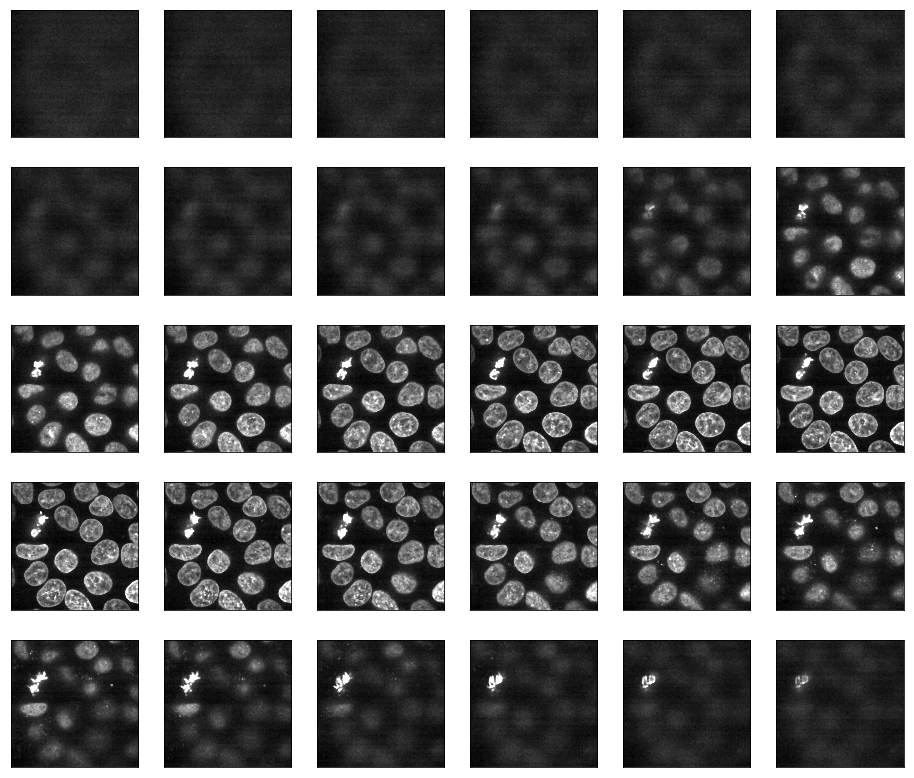

In [27]:
rescaled_uint8 = skimage.img_as_ubyte(rescaled)

median = np.empty_like(rescaled_uint8)

selem = skimage.morphology.square(3)

for plane, image in enumerate(rescaled_uint8):
    median[plane] = skimage.filters.median(image, selem=selem)
    
median = skimage.img_as_float(median)
    
display(median)

Similarly, a [bilateral filter](https://en.wikipedia.org/wiki/Bilateral_filter) is an edge-preserving, denoising filter. Each pixel is assigned a weighted average based on neighboring pixels. The weight is determined by spatial and radiometric similarity (e.g., distance between two colors).

`skimage.restoration.denoise_bilateral` requires a `multichannel` parameter. This determines Whether the last axis of the image is to be interpreted as multiple
    channels or another spatial dimension.

In [ ]:
bilateral = np.empty_like(rescaled)

for index, plane in enumerate(rescaled):
    bilateral[index] = skimage.restoration.denoise_bilateral(
        plane, 
        multichannel=False
    )

display(bilateral)

In [ ]:
_, (a, b, c, d) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

show_plane(a, rescaled[32], title="Original")
show_plane(b, gaussian[32], title="Gaussian")
show_plane(c, median[32], title="Median")
show_plane(d, bilateral[32], title="Bilateral")

In [ ]:
denoised = bilateral

In [ ]:
threshold_li = skimage.filters.threshold_li(denoised)
li = denoised >= threshold_li

threshold_otsu = skimage.filters.threshold_otsu(denoised)
otsu = denoised >= threshold_otsu

_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

plot_hist(a, denoised, "Thresholds (Li: red, Otsu: blue)")
a.axvline(threshold_li, c="r")
a.axvline(threshold_otsu, c="b")

show_plane(b, li[32], title="Li's threshold = {:0.3f}".format(threshold_li))
show_plane(c, otsu[32], title="Otsu's threshold = {:0.3f}".format(threshold_otsu))

In [ ]:
binary = li

display(binary)

## Morphological operations

In [ ]:
ball = skimage.morphology.ball(5)
print("ball shape: {}".format(ball.shape))

cube = skimage.morphology.cube(5)
print("cube shape: {}".format(cube.shape))

In [ ]:
closing = np.empty_like(rescaled)
dilation = np.empty_like(rescaled)
erosion = np.empty_like(rescaled)
opening = np.empty_like(rescaled)

binary_closing = np.empty_like(binary)
binary_dilation = np.empty_like(binary)
binary_erosion = np.empty_like(binary)
binary_opening = np.empty_like(binary)

selem = skimage.morphology.disk(3)

for plane, (image, binary_image) in enumerate(zip(rescaled, binary)):
    closing[plane] = skimage.morphology.closing(image, selem)
    dilation[plane] = skimage.morphology.dilation(image, selem)
    erosion[plane] = skimage.morphology.erosion(image, selem)
    opening[plane] = skimage.morphology.opening(image, selem)
    
    binary_closing[plane] = skimage.morphology.binary_closing(binary_image, selem)
    binary_dilation[plane] = skimage.morphology.binary_dilation(binary_image, selem)
    binary_erosion[plane] = skimage.morphology.binary_erosion(binary_image, selem)
    binary_opening[plane] = skimage.morphology.binary_opening(binary_image, selem)
    
_, ((a, b, c, d), (e, f, g, h)) = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

show_plane(a, closing[32], title="Closing")
show_plane(b, opening[32], title="Opening")
show_plane(c, erosion[32], title="Erosion")
show_plane(d, dilation[32], title="Dilation")

show_plane(e, binary_closing[32], title="Binary closing")
show_plane(f, binary_opening[32], title="Binary opening")
show_plane(g, binary_erosion[32], title="Binary erosion")
show_plane(h, binary_dilation[32], title="Binary dilation")

In [ ]:
a = 20

remove_holes = skimage.morphology.remove_small_holes(
    binary, 
    min_size=np.product(np.divide(a, spacing))
)

display(remove_holes)

In [ ]:
a = 40

remove_objects = skimage.morphology.remove_small_objects(
    remove_holes, 
    min_size=np.product(np.divide(a, spacing))
)

display(remove_objects)

## Segmentation

In [ ]:
def get_cmap(labels, name="viridis"):
    cmap = matplotlib.cm.get_cmap("viridis")
    masked_labels = np.ma.masked_where(labels == 0, labels)
    cmap.set_bad(color="black")
    
    return masked_labels, cmap

In [ ]:
labels = skimage.measure.label(remove_objects)

masked_labels, cmap = get_cmap(labels)

display(masked_labels, cmap=cmap)

In [ ]:
_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

show_plane(a, rescaled[32, :100, 125:], title="Rescaled")
show_plane(b, masked_labels[32, :100, 125:], cmap=cmap, title="Labels")
show_plane(c, labels[32, :100, 125:] == 8, title="Labels = 8")

In [ ]:
distance = ndi.distance_transform_edt(remove_objects)

peak_local_max = skimage.feature.peak_local_max(
    distance,
    footprint=np.ones((15, 15, 15), dtype=np.bool),
    indices=False,
    labels=skimage.measure.label(remove_objects)
)

markers = skimage.measure.label(peak_local_max)

labels = skimage.morphology.watershed(
    -rescaled, 
    markers, 
    mask=remove_objects
)

masked_labels, cmap = get_cmap(labels)

display(masked_labels, cmap=cmap)

In [ ]:
_, ((a, b, c), (d, e, f)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

show_plane(a, masked_labels[32, :100, 125:], cmap=cmap, title="Labels")
show_plane(b, labels[32, :100, 125:] == 20, title="Labels = 20")
show_plane(c, labels[32, :100, 125:] == 21, title="Labels = 21")

show_plane(d, masked_labels[32, 75:175, 125:], cmap=cmap, title="Labels")
show_plane(e, labels[32, 75:175, 125:] == 13, title="Labels = 13")
show_plane(f, labels[32, 75:175, 125:] == 14, title="Labels = 14")

In [ ]:
_, (a, b, c) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

show_plane(a, masked_labels[32, 156:, 20:150], cmap=cmap)
show_plane(b, masked_labels[34, 90:190, 126:], cmap=cmap)
show_plane(c, masked_labels[32, 150:, 118:248], cmap=cmap)

In [ ]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

vmin = distance.min()
vmax = distance.max()

for index, ax in enumerate(axes.flatten()):
    ax.imshow(
        -distance[31 + index],
        cmap="gray",
        vmin=-vmax,
        vmax=-vmin
    )
    
    peaks = np.nonzero(peak_local_max[31 + index])
    
    ax.plot(peaks[1], peaks[0], "r.")
    ax.set_xticks([])
    ax.set_yticks([])

## Feature extraction

In [ ]:
interior_labels = skimage.segmentation.clear_border(labels)

masked_labels, cmap = get_cmap(interior_labels)

print("interior labels: {}".format(np.unique(interior_labels)))

display(masked_labels, cmap=cmap)

In [ ]:
relabeled, _, _ = skimage.segmentation.relabel_sequential(interior_labels)

print("relabeled labels: {}".format(np.unique(relabeled)))

In [ ]:
regionprops = skimage.measure.regionprops(relabeled, intensity_image=data)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

In [ ]:
print("measured regions: {}".format(len(regionprops)))

In [ ]:
area = [regionprop.area for regionprop in regionprops]

print("area: {}".format(area))

In [ ]:
min_plane, min_row, min_col, max_plane, max_row, max_col = regionprops[3].bbox

bbox_img = data[min_plane:max_plane, min_row:max_row, min_col:max_col]

print("bounded image shape: {}".format(bbox_img.shape))

display(bbox_img, step=1)